In [12]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

            #guests
time               
2008-01-01      228
2008-02-01      129
2008-03-01       79
2008-04-01      111
2008-05-01      123
DatetimeIndex(['2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01', '2008-07-01', '2008-08-01',
               '2008-09-01', '2008-10-01',
               ...
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01'],
              dtype='datetime64[ns]', name='time', length=119, freq=None)


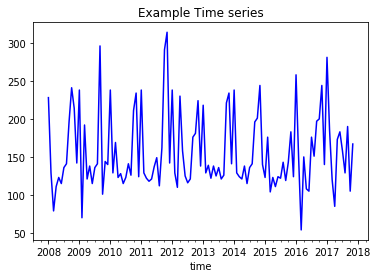

time
2008-01-01    228
2008-02-01    129
2008-03-01     79
2008-04-01    111
2008-05-01    123
2008-06-01    115
2008-07-01    136
2008-08-01    141
2008-09-01    196
2008-10-01    241
Name: #guests, dtype: int64

In [6]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('./data/hotelguests.csv', parse_dates=['time'], index_col='time',date_parser=dateparse)
print(data.head())
print(data.index)
ts = data['#guests']
ts.plot(c='b', title='Example Time series')
plt.show()
ts.head(10)

In [7]:
TS = np.array(ts)
num_periods = 6
f_horizon = 1
x_data = TS[:(len(TS)-(len(TS)% num_periods))]
x_batches = x_data.reshape(-1, 6, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods)) + f_horizon]
y_batches = y_data.reshape(-1, 6, 1)
print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:2])

print(y_batches[0:1])
print(y_batches.shape)

19
(19, 6, 1)
[[[228]
  [129]
  [ 79]
  [111]
  [123]
  [115]]

 [[136]
  [141]
  [196]
  [241]
  [214]
  [142]]]
[[[129]
  [ 79]
  [111]
  [123]
  [115]
  [136]]]
(19, 6, 1)


In [8]:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 6, 1)
    testY = TS[-(num_periods):].reshape(-1, 6, 1)
    return testX,testY
X_test, Y_test = test_data(TS, f_horizon, num_periods)
print(X_test.shape)
print(X_test)

(1, 6, 1)
[[[173]
  [183]
  [158]
  [129]
  [190]
  [105]]]


In [9]:
tf.reset_default_graph()

num_periods = 6
inputs = 1
hidden = 100
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
#BasicRNNCell
learning_rate = 0.001

stacked_rnn_output = tf.reshape(rnn_output,[-1,hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_sum(tf.square(outputs - y ))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()


In [10]:
epochs = 3000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 3685862.8
100 	MSE: 320290.03
200 	MSE: 200219.81
300 	MSE: 159360.86
400 	MSE: 107293.45
500 	MSE: 86823.04
600 	MSE: 87908.87
700 	MSE: 71335.83
800 	MSE: 65172.074
900 	MSE: 61745.53
1000 	MSE: 56379.43
1100 	MSE: 61683.645
1200 	MSE: 48923.96
1300 	MSE: 44564.137
1400 	MSE: 53033.38
1500 	MSE: 36894.223
1600 	MSE: 33992.047
1700 	MSE: 55625.137
1800 	MSE: 36733.242
1900 	MSE: 41703.53
2000 	MSE: 35086.746
2100 	MSE: 30568.936
2200 	MSE: 27771.342
2300 	MSE: 26687.455
2400 	MSE: 26244.512
2500 	MSE: 25451.592
2600 	MSE: 24220.98
2700 	MSE: 109198.71
2800 	MSE: 51084.824
2900 	MSE: 41889.082
[[[134.29625]
  [253.12816]
  [255.17166]
  [205.26852]
  [152.39789]
  [240.08786]]]


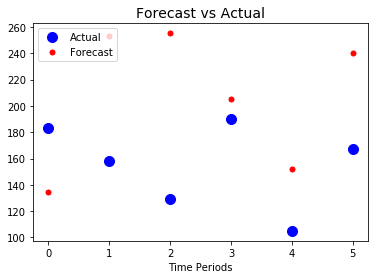

In [11]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'bo', markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), 'r.', markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()